## Define lib

In [37]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

from xgboost import XGBClassifier

## Load dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/project DA/fraud/fraud_v2.csv')

## Data preprocessing

In [3]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [4]:
df.rename(columns={"nameOrig": "name_org", "oldbalanceOrg": "oldbalance_org", "newbalanceOrig": "newbalance_org", "nameDest": "name_dest",\
                   "oldbalanceDest": "oldbalance_dest", "newbalanceDest": "newbalance_dest", "isFraud": "isfraud", "isFlaggedFraud" : "isflagged_fraud"}, inplace=True)

## Data cleaning

In [5]:
df.head()

,step,type,amount,name_org,oldbalance_org,newbalance_org,name_dest,oldbalance_dest,newbalance_dest,isfraud,isflagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.dtypes

step                 int64
type                object
amount             float64
name_org            object
oldbalance_org     float64
newbalance_org     float64
name_dest           object
oldbalance_dest    float64
newbalance_dest    float64
isfraud              int64
isflagged_fraud      int64
dtype: object

In [7]:
df.describe()

,step,amount,oldbalance_org,newbalance_org,oldbalance_dest,newbalance_dest,isfraud,isflagged_fraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Check null

In [8]:
df.isnull().sum().max()

0

### Check duplicate

In [9]:
df.duplicated().sum()

0

## EDA

In [13]:
transfer_fraud_transfer = df[((df['type']=='TRANSFER') & df['isfraud']==1)]
print("Number of the fraud has type is TRANSFER:" , len(transfer_fraud_transfer['name_org']))

transfer_fraud_cashout = df[((df['type']=='CASH_OUT') & df['isfraud']==1)]
print("Number of the fraud has type is CASH OUT:" , len(transfer_fraud_cashout['name_org']))

Number of the fraud has type is TRANSFER: 4097
Number of the fraud has type is CASH OUT: 4116


In [14]:
# transfer_fraud_tf = df[df['type'] == 'TRANSER']
transfer_cashout = df[df['type'] == 'CASH_OUT']

print('Has the fraud destination account used for cashing out?' , transfer_fraud_transfer['name_dest'].isin(transfer_cashout['name_org']).any())

Has the fraud destination account used for cashing out? True


In [15]:
transfer_fraud_transfer[transfer_fraud_transfer['name_dest'].isin(transfer_cashout['name_org'])]

,step,type,amount,name_org,oldbalance_org,newbalance_org,name_dest,oldbalance_dest,newbalance_dest,isfraud,isflagged_fraud
1030443,65,TRANSFER,1282971.57,C1175896731,1282971.57,0.0,C1714931087,0.0,0.0,1,0
6039814,486,TRANSFER,214793.32,C2140495649,214793.32,0.0,C423543548,0.0,0.0,1,0
6362556,738,TRANSFER,814689.88,C2029041842,814689.88,0.0,C1023330867,0.0,0.0,1,0


In [16]:
fraud = df[df['isfraud'] == 1]

# Filter fraud transactions involving customer-to-customer (C2C) transfers
fraud_2c = df[(df['isfraud'] == 1) & (df['name_dest'].str[0] == 'C')]

# Calculate the percentage of fraud transactions that are customer-to-customer
percent_c2c_fraud = (len(fraud_2c) / len(fraud)) * 100

# Print the result
print(f"Percent of the fraud transactions that are customer to customer: {percent_c2c_fraud:.2f}%")

Percent of the fraud transactions that are customer to customer: 100.00%


In [17]:
unflagged_transactions = df.loc[df['isflagged_fraud'] == 0]['amount']
has_large_amount = (unflagged_transactions > 2*10**5).any()

print("Are there any unflagged transactions with an amount lower than 200,000?", has_large_amount)

Are there any unflagged transactions with an amount lower than 200,000? True


In [18]:
print("Max amount for unflagged transactions: ", df.loc[df['isflagged_fraud'] == 0]['amount'].max())

Max amount for unflagged transactions:  92445516.64


In [19]:
df[df['oldbalance_org'] == df['amount']].isfraud.value_counts()

isfraud
1    8034
Name: count, dtype: int64

## Feature enginneering

In [20]:
def transaction_type(row):
    if row['name_org'][0] == 'C':
        if row['name_dest'][0] == 'C':
            return 'CC'  # Customer to Customer
        else:
            return 'CM'  # Customer to Merchant
    else:
        if row['name_dest'][0] == 'C':
            return 'MC'  # Customer to Customer
        else:
            return 'MM'  # Customer to Merchant

# Create new column 'transaction_type'
df['trans_2type'] = df.apply(transaction_type, axis=1)

In [21]:
trans_fraud = df[df['isfraud'] == 1]
trans_valid = df[df['isfraud'] == 0]

print('Number of fraud transactions according to type are below:\n', trans_fraud['trans_2type'].value_counts())
print('Number of valid transactions according to type are below:\n', trans_valid['trans_2type'].value_counts())

Number of fraud transactions according to type are below:
 trans_2type
CC    8213
Name: count, dtype: int64
Number of valid transactions according to type are below:
 trans_2type
CC    4202912
CM    2151495
Name: count, dtype: int64


## Data visualization

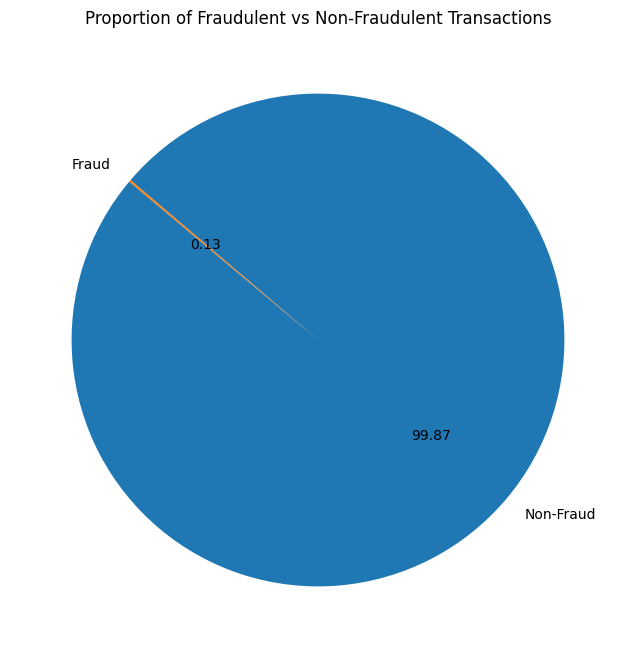

In [22]:
fraud_val = df['isfraud'].value_counts()
fraud_labels = ['Non-Fraud', 'Fraud']
fraud_sizes = fraud_val.values

plt.figure(figsize=(8, 8))
plt.pie(fraud_sizes, labels=fraud_labels, autopct=f'%.2f', startangle=140)
plt.title('Proportion of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

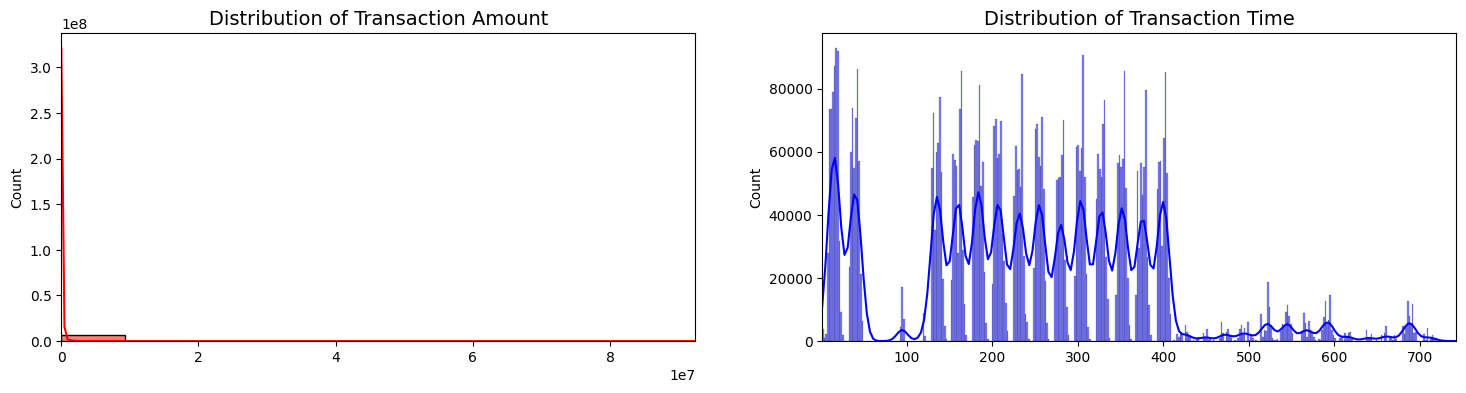

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

amount_val = df['amount'].values
time_val = df['step'].values

# Distribution plot for transaction amounts
sns.histplot(amount_val, ax=ax[0], color='r', kde=True, bins=10)
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

# Distribution plot for transaction times
sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

Text(0.5, 1.0, 'Fraudulent vs. Non-Fraudulent Transactions')

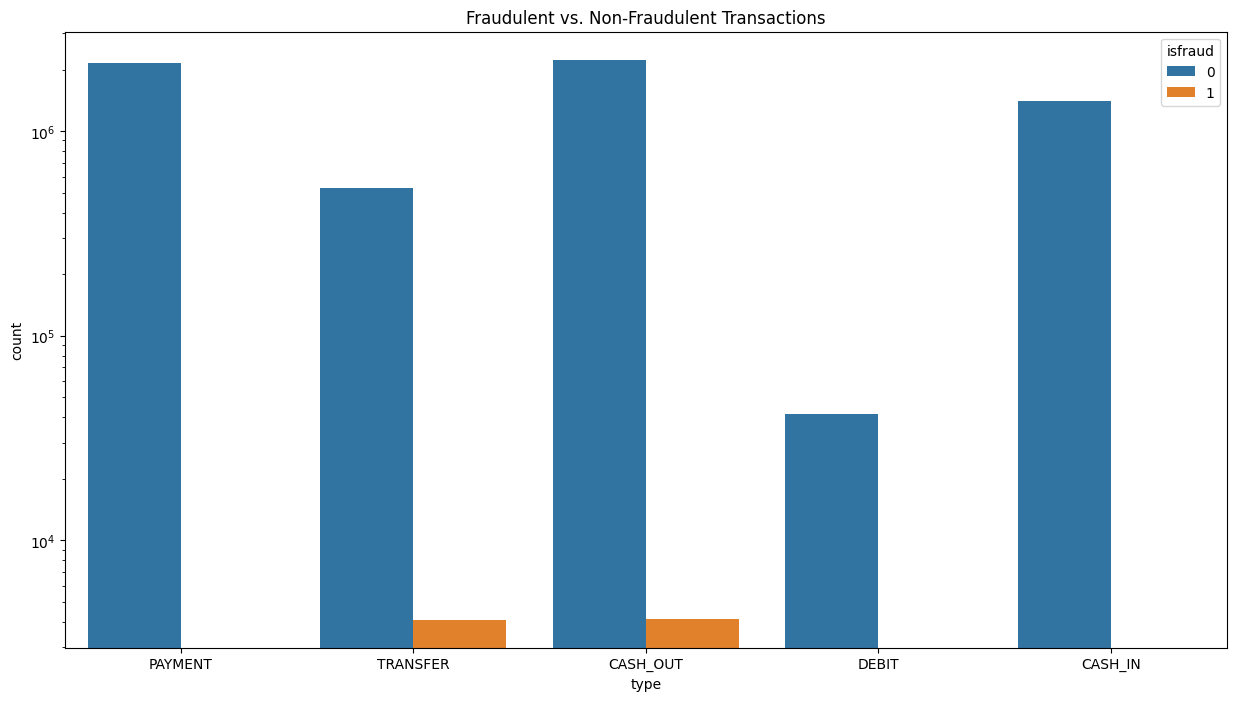

In [24]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(data=df, x="type", hue="isfraud")
plt.yscale('log')  # Use log scale for y-axis
plt.title('Fraudulent vs. Non-Fraudulent Transactions')

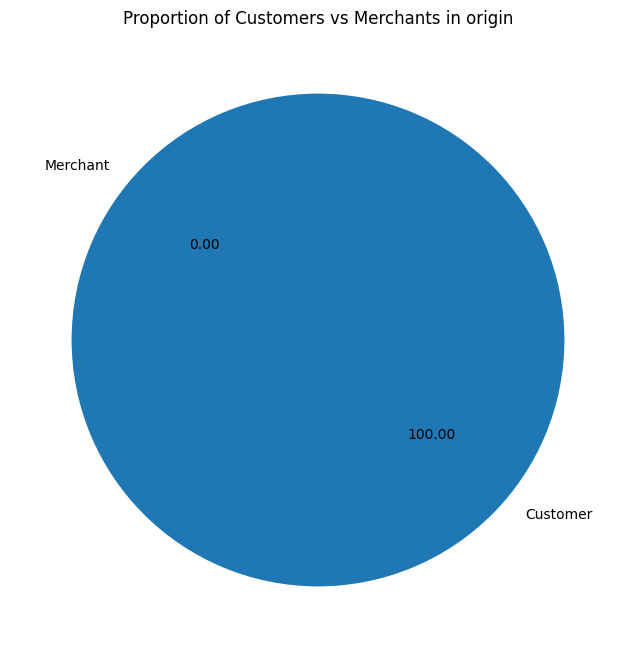

In [25]:
name_org_val = df['name_org'].str[0].value_counts()
name_org_labels = ['Customer', 'Merchant']
name_org_sizes = np.append(name_org_val.values, 0)

plt.figure(figsize=(8, 8))
plt.pie(name_org_sizes, labels=name_org_labels, autopct=f'%.2f', startangle=140)
plt.title('Proportion of Customers vs Merchants in origin')
plt.show()

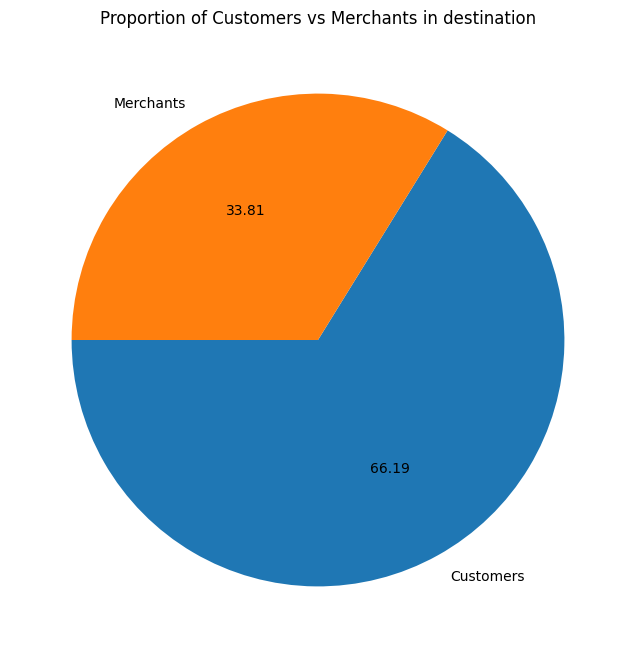

In [26]:
name_dest_val = df['name_dest'].str[0].value_counts()
name_dest_labels = ['Customers', 'Merchants']
name_dest_sizes = name_dest_val.values

plt.figure(figsize=(8, 8))
plt.pie(name_dest_sizes, labels=name_dest_labels, autopct=f'%.2f', startangle=180)
plt.title('Proportion of Customers vs Merchants in destination')
plt.show()

In [27]:
print(df['trans_2type'].value_counts())

trans_2type
CC    4211125
CM    2151495
Name: count, dtype: int64


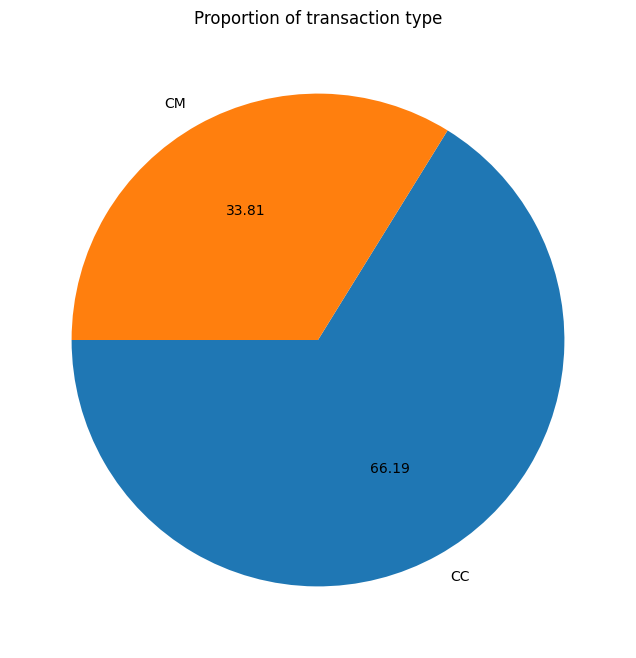

In [28]:
trans_type_val = df['trans_2type'].value_counts()
trans_type_labels = ['CC', 'CM']
trans_type_sizes = name_dest_val.values

plt.figure(figsize=(8, 8))
plt.pie(trans_type_sizes, labels=trans_type_labels, autopct=f'%.2f', startangle=180)
plt.title('Proportion of transaction type')
plt.show()

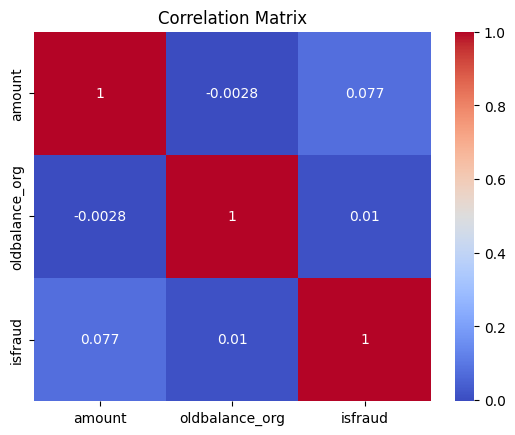

In [29]:
corr_matrix = df.drop(columns=['step', 'type', 'name_org',
       'newbalance_org', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
                               'isflagged_fraud', 'trans_2type']).corr()

# Visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Data modeling

In [30]:
df.drop(columns=['step', 'name_org', 'newbalance_org', \
                 'name_dest', 'oldbalance_dest', 'newbalance_dest', 'isflagged_fraud'], inplace=True)

In [31]:
X = df.drop('isfraud', axis=1)
y = df['isfraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [32]:
X.columns

Index(['type', 'amount', 'oldbalance_org', 'trans_2type'], dtype='object')

### Sampling

In [ ]:
# Calculate class distribution in the original dataset
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("Original class distribution:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} instances")

Original class distribution:
Class 0: 5083526 instances
Class 1: 6570 instances


#### Oversampling

In [ ]:
from imblearn.over_sampling import SMOTENC

smc = SMOTENC(random_state=42, categorical_features=[0, 3])
X_train_oversampled, y_train_oversampled = smc.fit_resample(X_train, y_train)

In [ ]:
unique_classes_oversampled, class_counts_oversampled = np.unique(y_train_oversampled, return_counts=True)

for cls, count in zip(unique_classes_oversampled, class_counts_oversampled):
    print(f"Class {cls}: {count} instances")

Class 0: 5083526 instances
Class 1: 5083526 instances


#### Undersampling

In [ ]:
def undersample_data(X_train, y_train):


    # Find the minority and majority class labels
    minority_class_label = unique_classes[np.argmin(class_counts)]
    majority_class_label = unique_classes[np.argmax(class_counts)]

    # Find indices of minority and majority class samples
    minority_indices = np.where(y_train == minority_class_label)[0]
    majority_indices = np.where(y_train == majority_class_label)[0]

    # Randomly sample from majority class indices to match minority class size
    num_minority_samples = len(minority_indices)
    undersampled_majority_indices = np.random.choice(majority_indices, size=num_minority_samples, replace=False)

    # Combine minority and undersampled majority indices
    undersampled_indices = np.concatenate([minority_indices, undersampled_majority_indices])

    # Undersampled dataset
    X_undersampled = X_train.iloc[undersampled_indices]
    y_undersampled = y_train.iloc[undersampled_indices]

    # Check class distribution after undersampling
    unique_classes_undersampled, class_counts_undersampled = np.unique(y_undersampled, return_counts=True)
    print("Class distribution after undersampling:")
    for cls, count in zip(unique_classes_undersampled, class_counts_undersampled):
        print(f"Class {cls}: {count} instances")

    return X_undersampled, y_undersampled

In [ ]:
X_train_undersampled, y_train_undersampled = undersample_data(X_train, y_train)

Class distribution after undersampling:
Class 0: 6570 instances
Class 1: 6570 instances


### Prepare for pipline

In [33]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
class_counts[0]/class_counts[1]

773.7482496194825

### XGBOOST

#### Normal

In [ ]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=770, colsample_bytree=1.0, gamma=0, max_depth=8, n_estimators=300, subsample=1.0))
])

In [ ]:
pipeline_xgb.fit(X_train, y_train)

y_pred = pipeline_xgb.predict(X_test)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.42      0.99      0.59      1643

    accuracy                           1.00   1272524
   macro avg       0.71      0.99      0.80   1272524
weighted avg       1.00      1.00      1.00   1272524

F1 Score: 0.5925655976676385


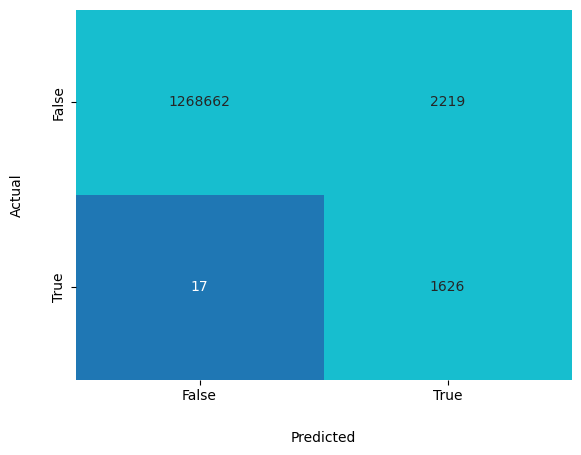

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(
    conf_matrix, annot=True, fmt='d',
    cbar=False, cmap='tab10', vmax=500,
    xticklabels=['False', 'True'],
    yticklabels=['False', 'True'])

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

##### Grid Search

In [ ]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=770))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [4, 5, 6, 7, 8],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.1]
}

skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline_xgb, param_grid, cv=skf, scoring='recall', verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
from sklearn.base import clone
def find_the_best(grid_search):
  # Get the best recall score
  best_recall = grid_search.best_score_

  # Get all the models that achieved the best recall
  results = grid_search.cv_results_
  recall_indices = [i for i, score in enumerate(results['mean_test_score']) if score > 0.99]
  best_f1 = 0
  best_params = None
  best_pp = None

  for index in recall_indices:
      params = results['params'][index]
      print(params)
      pipeline_xgb.set_params(**params)
      pipeline_xgb.fit(X_train, y_train)
      y_pred = pipeline_xgb.predict(X_test)
      f1 = f1_score(y_test, y_pred)

      if f1 > best_f1:
          best_f1 = f1
          best_params = params
          best_pp = clone(pipeline_xgb)
  return best_f1, best_params, best_pp

In [ ]:
best_f1, best_params, best_pp = find_the_best(grid_search)

In [ ]:
y_pred = grid_search.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(
    conf_matrix, annot=True, fmt='d',
    cbar=False, cmap='tab10', vmax=500,
    xticklabels=['False', 'True'],
    yticklabels=['False', 'True'])

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

#### Oversampling

In [ ]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, max_depth=6, subsample=0.8, colsample_bytree=1.0, gamma=0.1))
])

In [ ]:
pipeline_xgb.fit(X_train_oversampled, y_train_oversampled)

y_pred = pipeline_xgb.predict(X_test)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.28      1.00      0.43      1643

    accuracy                           1.00   1272524
   macro avg       0.64      1.00      0.72   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
[[1266601    4280]
 [      5    1638]]
F1 Score: 0.43327602169025264


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(
    conf_matrix, annot=True, fmt='d',
    cbar=False, cmap='tab10', vmax=500,
    xticklabels=['0', '1'],
    yticklabels=['0', '1'])

#### Undersampling

In [ ]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

In [ ]:
pipeline_xgb.fit(X_train_undersampled, y_train_undersampled)

y_pred = pipeline_xgb.predict(X_test)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1270881
           1       0.08      1.00      0.15      1643

    accuracy                           0.98   1272524
   macro avg       0.54      0.99      0.57   1272524
weighted avg       1.00      0.98      0.99   1272524

Confusion Matrix:
[[1251562   19319]
 [      3    1640]]
F1 Score: 0.14511990089372623


### Logistic Regression

#### Normal

In [ ]:
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [ ]:
param_grid = {
    'classifier__C': [0.1, 1, 3],  # Regularization parameter
    'classifier__class_weight': [None, 'balanced'],  # Class weight parameter
    'classifier__solver': ['liblinear', 'newton-cholesky']
}

skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline_lr, param_grid, cv=skf, scoring='f1', verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
pipeline_lr.fit(X_train, y_train)

y_pred = pipeline_lr.predict(X_test)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.81      0.14      0.24      1643

    accuracy                           1.00   1272524
   macro avg       0.91      0.57      0.62   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
[[1270827      54]
 [   1409     234]]
F1 Score: 0.24236147074054895


#### Oversampling

In [ ]:
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [ ]:
pipeline_lr.fit(X_train_oversampled, y_train_oversampled)

y_pred = pipeline_lr.predict(X_test)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97   1270881
           1       0.02      0.94      0.04      1643

    accuracy                           0.93   1272524
   macro avg       0.51      0.94      0.50   1272524
weighted avg       1.00      0.93      0.96   1272524

Confusion Matrix:
[[1186598   84283]
 [     99    1544]]
F1 Score: 0.03530353263976221


#### Undersampling

In [ ]:
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [ ]:
pipeline_lr.fit(X_train_undersampled, y_train_undersampled)

y_pred = pipeline_lr.predict(X_test)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93   1270881
           1       0.01      0.89      0.02      1643

    accuracy                           0.88   1272524
   macro avg       0.50      0.88      0.48   1272524
weighted avg       1.00      0.88      0.93   1272524

Confusion Matrix:
[[1112845  158036]
 [    183    1460]]
F1 Score: 0.01812100112325384


### Random Forest

In [40]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [ ]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=skf, scoring='f1', verbose=4)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_params_

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred))

## Export final cleaned dataset

In [ ]:
df.to_csv('/content/fraud_final.csv', index=False)